In [1]:
#imports various libraries including NumPy, pandas, TensorFlow, and SHAP. 
#These libraries are used for numerical operations, data manipulation, machine learning, and SHAP explanations
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
import warnings
import logging

warnings.filterwarnings("ignore")
logger = logging.getLogger('shap')
logger.disabled = True

class AnomalyExplanationUsingSHAP:
    '''
    This class implements the method described in 'Explaining Anomalies Detected by Autoencoders Using SHAP' to explain
    anomalies revealed by an unsupervised Autoencoder model using SHAP.
    '''
    
    model_autoencoder = None
    num_anomalies_to_explain = None
    reconstruction_error_percentage = None
    shap_values_selection_method = None
    counter = None

    def __init__(self, num_anomalies=100, reconstruction_error_percent=0.5, shap_selection='mean'):
        """
        Args:
            num_anomalies_to_explain (int): number of top ranked anomalies (ranked by anomaly score that is the mse) to
                                            explain.
            reconstruction_error_percent (float): Number between 0 to 1- see explanation to this parameter in
                                                  'Explaining Anomalies Detected by Autoencoders Using SHAP' under
                                                  ReconstructionErrorPercent.
            shap_values_selection (str): One of the possible methods to choose explaining features by their SHAP values.
                                         Can be: 'mean', 'median', 'constant'. See explanation to this parameter in
                                         'Explaining Anomalies Detected by Autoencoders Using SHAP' under
                                         SHAPvaluesSelection.
        """
        self.num_anomalies_to_explain = num_anomalies
        self.reconstruction_error_percentage = reconstruction_error_percent
        self.shap_values_selection_method = shap_selection

    def train_autoencoder(self, train_data, epochs=5, batch_size=64):
        """
        Train 6-layer Autoencoder model on the given x_train data.

        Args:
            x_train (data frame): The data to train the Autoencoder model on
            nb_epoch (int): Number of epoch the model will perform
            batch_size (int): Size of each batch of data enter to the model

        Returns:
            model: Trained autoencoder
        """
        input_dim = train_data.shape[1]
        print('Training data features:', input_dim)

        input_layer = Input(shape=(input_dim,))
        encoder = Dense(10, activation="relu", activity_regularizer=regularizers.l1(10e-7))(input_layer)
        encoder = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(10e-7))(encoder)
        decoder = Dense(10, activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)
        decoder = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(10e-7))(decoder)
        decoder = Dense(input_dim, activation=None, kernel_regularizer=regularizers.l2(10e-7))(decoder)

        self.model_autoencoder = Model(inputs=input_layer, outputs=decoder)
        self.model_autoencoder.summary()

        self.model_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

        early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
        self.model_autoencoder.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True,
                                   validation_split=0.1, verbose=2, callbacks=[early_stopper])
        self.model_autoencoder.save("autoencoder.h5")

        return self.model_autoencoder
                
    def get_top_anomalies_to_explain(self, explain_data):
        """
        Sort all records in x_explain by their MSE calculated according to their prediction by the trained Autoencoder
        and return the top num_anomalies_to_explain (its value given by the user at class initialization) records.

        Args:
            x_explain (data frame): Set of records we want to explain the most anomalous ones from it.

        Returns:
            list: List of index of the top num_anomalies_to_explain records with highest MSE that will be explained.
        """
        predictions = self.model_autoencoder.predict(explain_data)
        squared_errors = np.power(explain_data - predictions, 2)
        mse_series = pd.Series(np.mean(squared_errors, axis=1))

        most_anomalous_transactions = mse_series.sort_values(ascending=False)
        columns = ["id", "mse_all_columns"]
        columns.extend(["squared_error_" + col for col in list(explain_data.columns)])
        items = []
        for x in most_anomalous_transactions.iteritems():
            item = [x[0], x[1]]
            item.extend(squared_errors.loc[x[0]])
            items.append(item)

        anomalies_df = pd.DataFrame(items, columns=columns)
        anomalies_df.set_index('id', inplace=True)

        top_anomalies_to_explain = anomalies_df.head(self.num_anomalies_to_explain).index
        return top_anomalies_to_explain

    def get_num_features_with_high_reconstruction_error(self, total_squared_error, errors_df):
        """
        Calculate the number of features whose reconstruction errors sum to reconstruction_error_percent of the
        total_squared_error of the records that selected to be explained at the moment. This is the number of the
        top reconstructed errors features that going to be explained and eventually this features together with their
        explanation will build up the features explanation set of this record.

        Args:
            total_squared_error (int): MSE of the records selected to be explained
            errors_df (data frame): The reconstruction error of each feature- this is the first output output of
                                    get_errors_df_per_record function

        Returns:
            int: Number of features whose reconstruction errors sum to reconstruction_error_percent of the
                 total_squared_error of the records that selected to be explained at the moment
        """
        error_sum = 0
        num_features = 0
        for index in errors_df.index:
            error_sum += errors_df.loc[index, 'err']
            if error_sum >= self.reconstruction_error_percentage * total_squared_error:
                break
            num_features += 1
        return num_features

    def get_background_set(self, train_data, background_size=200):
        """
        Get the first background_size records from x_train data and return it. Used for SHAP explanation process.

        Args:
            x_train (data frame): the data we will get the background set from
            background_size (int): The number of records to select from x_train. Default value is 200.

        Returns:
            data frame: Records from x_train that will be the background set of the explanation of the record that we
                        explain at that moment using SHAP.
        """
        background_set = train_data.head(background_size)
        return background_set

    def get_error_df_per_record(self, record):
        """
        Create data frame of the reconstruction errors of each features of the given record. Eventually we get data
        frame so each row contain the index of feature, its name, and its reconstruction error based on the record
        prediction provided by the trained autoencoder. This data frame is sorted by the reconstruction error of the
        features

        Args:
            record (pandas series): The record we explain at the moment; values of all its features.

        Returns:
            data frame: Data frame of all features reconstruction error sorted by the reconstruction error.
        """
        prediction = self.model_autoencoder.predict(np.array([[record]])[0])[0]
        squared_errors = np.power(record - prediction, 2)
        errors_df = pd.DataFrame({'col_name': squared_errors.index, 'err': squared_errors}).reset_index(drop=True)
        total_mse = np.mean(squared_errors)
        errors_df.sort_values(by='err', ascending=False, inplace=True)
        return errors_df, total_mse

    def get_high_shap_values(self, shap_values_df):
        """
        Choosing explaining features based on their SHAP values by shap_values_selection method (mean, median, constant)
        i.e. remove all features with SHAP values that do not meet the method requirements as described in 'Explaining
        Anomalies Detected by Autoencoders Using SHAP' under SHAPvaluesSelection.

        Args:
            shap_values_df (data frame): Data frame with all existing features and their SHAP values.

        Returns:
            data frame: Data frame that contain for each feature we explain (features with high reconstruction error)
                        its explaining features that selected by the shap_values_selection method and their SHAP values.
        """
        high_contributing_features_df = pd.DataFrame()

        for i in range(shap_values_df.shape[0]):
            shap_values = shap_values_df.iloc[i]
            if self.shap_values_selection_method == 'mean':
                threshold_value = np.mean(shap_values)
            elif self.shap_values_selection_method == 'median':
                threshold_value = np.median(shap_values)
            elif self.shap_values_selection_method == 'constant':
                num_explaining_features = 5
                explaining_features = shap_values_df[i:i + 1].stack().nlargest(num_explaining_features)
                high_contributing_features_df = pd.concat([high_contributing_features_df, explaining_features], axis=0)
                continue
            else:
                raise ValueError('Unknown SHAP value selection method')

            num_contributing_features = 0
            for j in range(len(shap_values)):
                if shap_values[j] > threshold_value:
                    num_contributing_features += 1
            contributing_features = shap_values_df[i:i + 1].stack().nlargest(num_contributing_features)
            high_contributing_features_df = pd.concat([high_contributing_features_df, contributing_features], axis=0)
        return high_contributing_features_df

    def predict_feature(self, record):
        """
        Predict the value of specific feature (with 'counter' index) using the trained autoencoder

        Args:
            record (pandas series): The record we explain at the moment; values of all its features.

        Returns:
            list: List the size of the number of features, contain the value of the predicted features with 'counter'
                  index (the feature we explain at the moment)
        """

        record_prediction = self.model_autoencoder.predict(record)[:, self.counter]
        return record_prediction

    def explain_unsupervised_data(self, train_data, explain_data, autoencoder=None, return_shap_values=False):
        """
        Explanation Process:
        1. If no Autoencoder model is provided ('autoencoder' is None), a new Autoencoder model is trained on the given 'x_train' data.
        2. For each record in 'top_records_to_explain', selected from the given 'x_explain' based on the 'get_top_anomaly_to_explain' function:
           a. SHAP is used to explain features with the highest reconstruction error as determined by the 'get_num_features_with_highest_reconstruction_error' function.
           b. SHAP values of each feature in the explanation are obtained for the high-reconstruction-error feature.
           c. Explaining features are selected using the 'highest_contributing_features' function.
        3. The explanation features set is constructed:
           a. Starting with the feature with the highest reconstruction error and its explaining features.
           b. Subsequent features with lower reconstruction errors and their corresponding explaining features are added, ensuring no duplicates.

        Args:
            x_train (DataFrame): Data used to train the autoencoder model and select the background set for SHAP explanation.
            x_explain (DataFrame): Data from which the top 'num_anomalies_to_explain' records are selected based on their MSE for explanation.
            autoencoder (model): Trained Autoencoder model to explain 'x_explain' data. If None, a new Autoencoder model is trained as described in the 'train_model' function.
            return_shap_values (bool): If False, explanation feature sets for each record include only feature names. If True, SHAP values are included, forming tuples of (str, float) where str is the explaining feature name and float is its SHAP value.
                                      Note: Explained features with no previous feature explanation (higher reconstruction error) will have a unique SHAP value of -1.
        Returns:
            dict: A dictionary containing explanations for 'top_records_to_explain' records. Keys are record indexes (int), and values are lists representing explanation feature sets.
        """

        self.model_autoencoder = autoencoder
        if self.model_autoencoder is None:
            self.train_autoencoder(train_data)

        top_anomalies_to_explain = self.get_top_anomalies_to_explain(explain_data)
        all_feature_sets_explanation = {}

        for record_idx in top_anomalies_to_explain:
            record_to_explain = explain_data.loc[record_idx]
            error_df, total_mse = self.get_error_df_per_record(record_to_explain)
            num_of_features = self.get_num_features_with_high_reconstruction_error(total_mse * error_df.shape[0], error_df)

            top_error_df = error_df.head(num_of_features)
            all_feature_sets_explanation[record_idx] = []
            shap_values_all_features = [[] for num in range(num_of_features)]

            background_set = self.get_background_set(train_data, 200).values
            for i in range(num_of_features):
                self.counter = top_error_df.index[i]
                explainer = shap.KernelExplainer(self.predict_feature, background_set)
                shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
                shap_values_all_features[i] = shap_values

            shap_values_all_features = np.fabs(shap_values_all_features)
            shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=train_data.columns)
            highest_contributing_features = self.get_high_shap_values(shap_values_all_features)

            for idx_explained_feature in range(num_of_features):
                feature_set = []
                for idx, row in highest_contributing_features.iterrows():
                    if idx[0] == idx_explained_feature:
                        feature_set.append((idx[1], row[0]))
                explained_feature_index = top_error_df.index[idx_explained_feature]
                feature_set.insert(0, (train_data.columns[explained_feature_index], -1))

                all_feature_sets_explanation[record_idx].append(feature_set)

            final_feature_set = []
            final_feature_items = []
            for item in sum(all_feature_sets_explanation[record_idx], []):
                if item[0] not in final_feature_set:
                    final_feature_set.append(item[0])
                    final_feature_items.append(item)

            if return_shap_values:
                all_feature_sets_explanation[record_idx] = final_feature_items
            else:
                all_feature_sets_explanation[record_idx] = final_feature_set

        return all_feature_sets_explanation

In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Read the benign dataset from the specified CSV file
benign = pd.read_csv(r"C:/Users\sampa\Desktop\dataset\REGULAR.csv")
# Read the attack dataset from the specified CSV file
Attack = pd.read_csv(r"C:/Users\sampa\Desktop\dataset\IOT\Hulk-Evasive.csv")


# selected columns (Add more columns)
# cols is the column list for benign dataset
cols = ['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s','FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts','Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max','Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance','RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes']

# catt_cols is the column list for attack dataset (including Label column)
att_cols = ['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s','FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts','Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max','Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance','RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes','Label']

#%%
# filter columns
benign = benign[cols]
# remove inf values
benign = benign.replace([np.inf], np.nan)
benign.dropna(inplace=True)

# filter columns
Attack = Attack[att_cols]
# remove inf values
Attack = Attack.replace([np.inf], np.nan)
Attack.dropna(inplace=True)

#%%
# data normalization (this will convert all columns to 0-1 range)
scaler = MinMaxScaler()
fit_scaling = scaler.fit(benign)
fit_apply = fit_scaling.transform(benign)  # fit the scaler for benign dataset
benign_norm = pd.DataFrame(fit_apply, columns=benign.columns, index=benign.index)

Attack_label = Attack[['Label']]
Attack_X = Attack.drop('Label', axis=1)
fit_apply = fit_scaling.transform(Attack_X)  # apply normalization to attack dataset
attack_norm = pd.DataFrame(fit_apply, columns=Attack_X.columns, index=Attack_X.index)



# data preparation for autoencoder model
X_train = benign_norm   # convert pandas dataframe into a array
X_test = attack_norm


In [4]:
X_train.head()

,Flow Packets/s,Fwd PSH Flags,Fwd Packets/s,Bwd Packets/s,FIN Flag Count,PSH Flag Count,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Fwd Act Data Pkts,...,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,RST Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes,Subflow Bwd Bytes
0,0.000340,0.000000,0.000681,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000082,0.000000,0.000164,0.00000,0.0,0.000000,0.018674,0.027211,0.004687,0.215947,...,0.041436,0.125636,0.000000,0.000000,0.0,0.125636,0.457317,0.000000,0.457317,0.000000
2,0.000015,0.000000,0.000030,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000879,0.128205,0.001147,0.00059,0.0,0.042272,0.000000,0.000000,0.000000,0.046512,...,0.019890,0.018598,0.010679,0.000114,0.0,0.018598,0.045732,0.012796,0.028963,0.010059
4,0.000319,0.923077,0.000316,0.00031,0.0,0.145310,0.000000,0.000000,0.000000,0.355482,...,0.019890,0.013767,0.010207,0.000104,0.0,0.013767,0.098448,0.000208,0.048780,0.000000


In [6]:
X_test.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [7]:
X_train.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [8]:
X_test.shape

(757027, 26)

In [9]:
Attack.Label.value_counts()

Hulk-Evasive    756987
BENIGN              40
Name: Label, dtype: int64

In [10]:
# Create an instance of the AnomalyExplanationUsingSHAP class with the specified number of anomalies
exp_model = AnomalyExplanationUsingSHAP(num_anomalies=2)


In [11]:
# Obtain explanations for anomaly detection using the instance of exp_model.
# The explanations are generated for the given training data (X_train) and
# the data to be explained (X_test). SHAP values will be returned for each explanation.
all_feature_sets_explanation = exp_model.explain_unsupervised_data(train_data=X_train, 
                                                                   explain_data=X_test,
                                                                   return_shap_values=True)


Training data features: 26
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 10)                270       
                                                                 
 dense_1 (Dense)             (None, 32)                352       
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 32)                352       
                                                                 
 dense_4 (Dense)             (None, 26)                858       
                                                                 
Total params: 2,162
Trainable para

In [12]:
# A dictionary containing explanations for each record in the dataset.(For training data)
# The keys represent record indexes, and the values are lists of explanation feature sets.
all_feature_sets_explanation

{573735: [('Bwd Packet Length Std', -1),
  ('Flow Packets/s', 0.46903039468179697),
  ('Bwd Packets/s', 0.23831491110150982),
  ('Fwd Packets/s', 0.10790319080536703),
  ('RST Flag Count', 0.05254859136531481)],
 4: [('Bwd Packet Length Std', -1),
  ('Flow Packets/s', 0.45697032964607),
  ('Bwd Packets/s', 0.22505317459077911),
  ('Fwd Packets/s', 0.09795374685566322),
  ('RST Flag Count', 0.05780982698058157)]}

In [13]:
 # define X_train
X_train = benign_norm.to_numpy() 

In [17]:
X_train.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [18]:
print(len(X_train.columns))
print(len(X_test.columns))

26
26


In [19]:
X_test.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [20]:
# threshold estimation using benign dataset
# predictions for benign dataset
import tensorflow
autoencoder = tensorflow.keras.models.load_model("autoencoder.h5")
x_pred_benign = autoencoder.predict(X_train)
benignMAE = np.mean(np.abs(X_train - x_pred_benign), axis=1)  # raw wise MAE calculation
benign_norm['MAE'] = benignMAE  # add MAE as a column to benignMAE dataframe
threshold = benign_norm['MAE'].quantile(0.99)  # 0.99 quantile threshold
threshold_max = benign_norm['MAE'].max()  # maximum threshold

9506/9506 [==============================] - 8s 867us/step


In [21]:
#%%
# autoencoder prediction results for attack dataset
x_pred_attack = autoencoder.predict(X_test)
attackMAE = np.mean(np.abs(X_test - x_pred_attack), axis=1)  # raw wise MAE calculation
Attack['MAE'] = attackMAE
Attack['pred_label'] = np.where(Attack['MAE']>threshold,1,0)


23658/23658 [==============================] - 21s 880us/step


In [22]:
print(len(X_train.columns))
print(len(X_test.columns))
X_train = X_train.drop('MAE',1)
print(len(X_train.columns))

27
26
26


In [23]:
# x test with predicted labels
X_test['pred_label'] = Attack['pred_label']

# select only attack data 
X_test_attack = X_test[X_test['pred_label']==1]
print(X_test_attack.shape)
# drop pred_lable column 
X_test_attack_new = X_test_attack.drop(['pred_label'], axis=1, inplace=True)
# print(X_test_attack_new.shape)

(757000, 27)


In [24]:
X_test_attack.columns

Index(['Flow Packets/s', 'Fwd PSH Flags', 'Fwd Packets/s', 'Bwd Packets/s',
       'FIN Flag Count', 'PSH Flag Count', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Fwd Act Data Pkts',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'RST Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg',
       'Bwd Segment Size Avg', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')

In [25]:
X_train=pd.DataFrame(X_train)

In [26]:
len(X_train.columns)

26

In [27]:
len(X_test_attack.columns)

26

In [28]:
exp_model = AnomalyExplanationUsingSHAP(num_anomalies=5)


In [29]:
# model only for attack data 'X_test_attack'

all_sets_explaining_features = exp_model.explain_unsupervised_data(train_data=X_train, 
                                                                   explain_data=X_test_attack,
                                                                   return_shap_values=True)


Training data features: 26
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_5 (Dense)             (None, 10)                270       
                                                                 
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
 dense_8 (Dense)             (None, 32)                352       
                                                                 
 dense_9 (Dense)             (None, 26)                858       
                                                                 
Total params: 2,162
Trainable pa

In [46]:
# A dictionary containing explanations for each record in the dataset.(For Attack data)
all_sets_explaining_features

{602902: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.22236648530019965),
  ('Flow Packets/s', 0.20173666879070629)],
 718029: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.22101828334499202),
  ('Flow Packets/s', 0.19778217858526576)],
 384574: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.22109119616268658),
  ('Flow Packets/s', 0.20720393419003674)],
 686625: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.22355549765055377),
  ('Flow Packets/s', 0.19770059419310443)],
 573735: [('Fwd Packets/s', -1),
  ('Bwd Packets/s', 0.1995736442579592),
  ('Flow Packets/s', 0.17054043903637822)]}

In [54]:
op = dict(all_sets_explaining_features[573735])

In [55]:
type (op)

dict

In [56]:
def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct

In [57]:
D = Convert(all_sets_explaining_features[573735])

In [58]:
D=op

([<matplotlib.axis.XTick at 0x2b0ba8a5eb0>,
 [Text(0, 0, 'Fwd Packets/s'),
  Text(1, 0, 'Bwd Packets/s'),
  Text(2, 0, 'Flow Packets/s')])

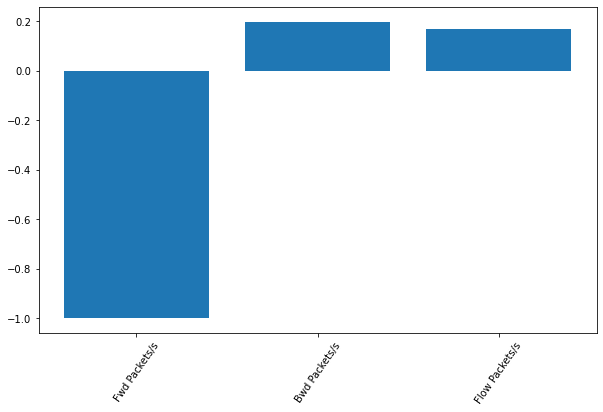

In [59]:
plt.figure(figsize=(10,6))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(rotation = 55) 
plt.xticks(range(len(D)), list(D.keys()))